In [ ]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
#import seaborn as s
import ase
from ase.io import read, write
import numpy as np
import numpy.random as npr
from ase.io import read,write
from ase.visualize import view
from ase import Atoms
import sys,os
#import mkl
from glob import glob
from copy import copy
#from sklearn.model_selection import KFold,ParameterGrid
from tqdm import tqdm_notebook
import cPickle as pck
from copy import copy

import quippy as qp

from sklearn import manifold, datasets
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from ase.data.colors  import jmol_colors
from ase.data import atomic_numbers
from soap_utils import get_frame_slices, get_fingerprints, get_chunck, get_Nsoap,get_spkitMax,ase2qp
bohr_to_ang = 0.52917720859


In [198]:
structure_cif = '/scratch/kahle/md-data/lgpo-constr.cif'
trajectory_file = '/scratch/kahle/md-data/lgpo-pw-constr/Li20Ge2P4O24-688.pos'
NAT = 50
NATp1 = 51
N_LI = 20
N_HOST = 30
N_LI_PER_FRAME = 1
STEPS = 1000
STEPSIZE = 55
Ge2P = True
atoms = read(structure_cif)
atom_1Li = Atoms(atoms[19:])

REPLACEMENTS = {
    32:15, # make Germanium Phosphorus
    #32:8, # Make everything O
    #15:8,
}

atom_1Li.set_atomic_numbers([REPLACEMENTS.get(a,a) for a in atom_1Li.get_atomic_numbers()])

frames = []

istep = 0
cell = atoms.get_cell(complete=True)
#cellT = cell.T
cellI = np.matrix(cell).I
#cellTI = np.matrix(cellT).I
#print cell
#print cellT

STST = STEPS*STEPSIZE

with open(trajectory_file) as fin:
    while (istep != STST):
        if istep % STEPSIZE == 0:
            assert fin.next().startswith('>')
            pos = np.empty((NAT, 3))
            for i in range(NAT):
                pos[i] = map(float, fin.next().split()[1:])
                #print pos[i]
            pos *= bohr_to_ang
            
            fractional_pos = np.dot(pos, cellI) ##np.linalg.solve(cellT, pos.T).T
            wrapped_fractional_pos = np.array(fractional_pos)[:,:] % 1.000
            wrapped_pos = np.dot(wrapped_fractional_pos, cell)

            # I set the positions for everything N-nonLi
            atom_1Li.set_positions(wrapped_pos[-(N_LI_PER_FRAME+N_HOST):])
            for i in range(N_LI):
                #print i, wrapped_pos[i], wrapped_pos[i]/bohr_to_ang
                atom_1Li[0].position = wrapped_pos[i]
                frames.append(ase2qp(atom_1Li))

        else:
            # SKIP LINES:
            for i in range(NATp1):
                fin.next()
        istep += 1

print len(frames)
#view(atoms)


20000


In [199]:

spkitMax = get_spkitMax(frames)
soap_param = dict(nocenters=[8,15,32], chem_channels=False, centerweight=1.0, 
                  gaussian_width=0.4, cutoff=3., cutoff_transition_width=0.5, 
                  nmax=20, lmax=8, nprocess=8, spkitMax=spkitMax,
                  dispbar=True, is_fast_average=False)
Nsoap = get_Nsoap(spkitMax=soap_param['spkitMax'], nmax=soap_param['nmax'], lmax=soap_param['lmax'])
soaps,slices,strides  = get_fingerprints(frames, soap_param)
del slices  # Free memory
del strides # Free memory

In [200]:
D = 30
pca = PCA(n_components=D)
pca.fit(soaps)
J=pca.transform(soaps)
print pca.explained_variance_ratio_.cumsum()

[0.53001001 0.76660757 0.84623685 0.88057243 0.91073388 0.92829412
 0.94300329 0.95233922 0.9598663  0.96689115 0.97318691 0.97736151
 0.98042504 0.9831849  0.98543143 0.9869505  0.98832667 0.98965875
 0.99082598 0.99167344 0.99246296 0.99319536 0.99378319 0.99431403
 0.99481879 0.99526129 0.99565237 0.99601265 0.99636057 0.9966578 ]


In [201]:
#from sklearn.manifold import TSNE
#X_embedded = TSNE(n_components=3).fit_transform(J)
#plt.figure(figsize=(12,7))
#X,Y,C = X_embedded.T.tolist()
#plt.scatter(X,Y, c=C)
#plt.show()

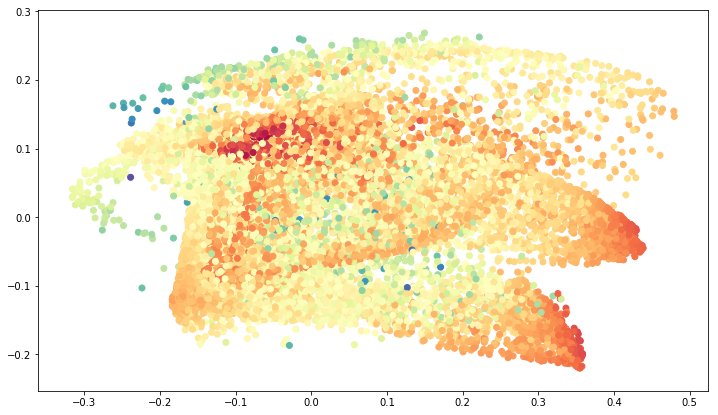

(20000, 30)


In [202]:
plt.figure(figsize=(12,7))
X,Y,C = J.T[:3].tolist()
plt.scatter(X,Y,
            c=C,
            #c=clusters,
            cmap=cm.Spectral)
plt.show()
print J.shape

In [203]:
FSPREAD = 1.4
#NGRID = 4000 #int(np.sqrt(len(J)+200))
METHOD = 'fspread'
NGRID = int(np.sqrt(len(J)+200))

np.savetxt('transformed-PCA.txt', J)
os.system('./pamm -d {1} -o res -{METHOD} {FSPREAD} -ngrid {NGRID} -v -savegrid -savevoronois < transformed-PCA.txt'.format(
        *J.shape,FSPREAD=FSPREAD, NGRID=NGRID, METHOD=METHOD))
grid = np.loadtxt('res.grid')
voronoi_assoc = np.loadtxt('res.voronoislinks')
assoc = np.array(voronoi_assoc[:,1], dtype=int) - 1
clusters = np.array(grid[assoc, J.shape[1]], dtype=int)

1 10426
2 2458
3 33
4 2257
5 3984
6 778
7 64
7 7 (20000,) (20000, 3)


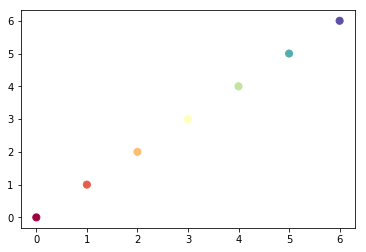

In [204]:
#positions = np.empty((20*len(frames, 3)))
positions = np.concatenate([f.positions[:N_LI_PER_FRAME] for f in frames])

#cell = delithiated.cell
clusters_int = map(int, clusters)
for i in sorted(set(clusters_int)):
    print i, clusters_int.count(i)

N_CLUSTERS = len(set(clusters_int))
print N_CLUSTERS, clusters.max(), clusters.shape, positions.shape
plt.scatter(range(N_CLUSTERS), range(N_CLUSTERS), c=range(N_CLUSTERS), cmap=cm.Spectral,s=50)
plt.show()

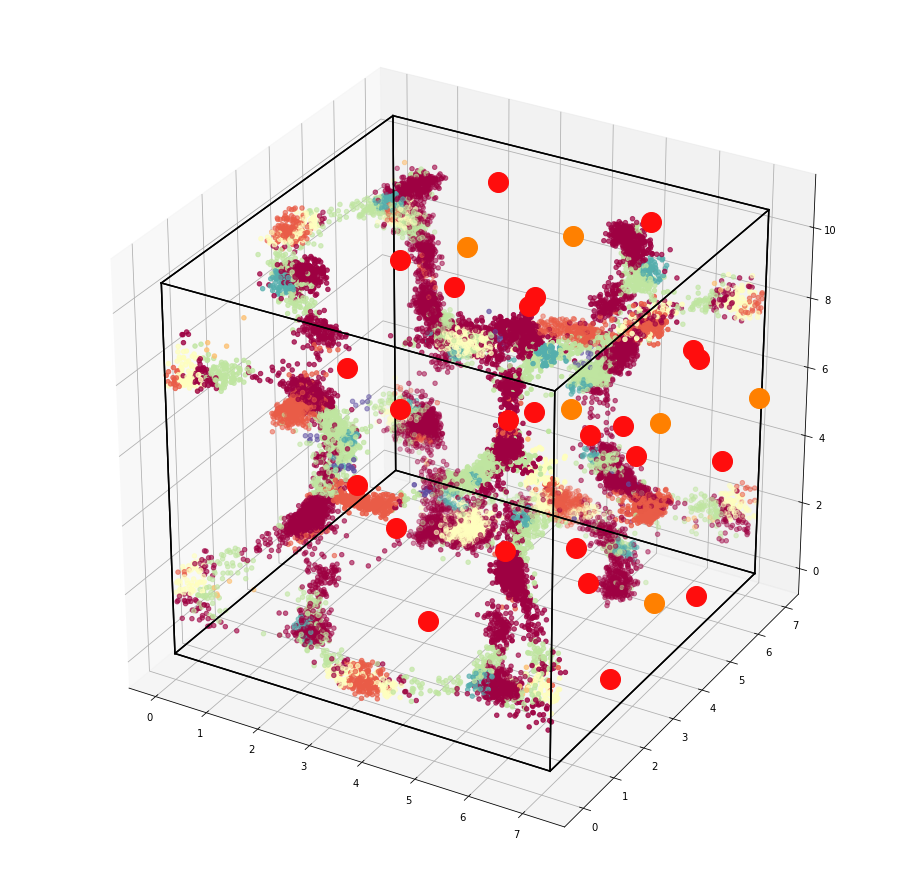

In [205]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
pp = [[i,j,k] for i in range(2) for j in range(2) for k in range(2)]
f = frames[0]
cell = f.cell
for p1 in pp:
    for p2 in pp:
        counts = [p1[i] == p2[i] for i in range(3)]
        if not counts.count(True) == 2:
            continue
        ax.plot(*zip(np.dot([p1], cell).tolist()[0], np.dot([p2], cell).tolist()[0]), color=(0,0,0))


for at, pos in zip(f.get_atomic_numbers(), f.get_positions())[N_LI_PER_FRAME:]:
    color = jmol_colors[at]
    ax.plot(*zip(pos), marker='o',  color=color, markersize=20)

ax.scatter(*positions.T, c=clusters, cmap=cm.Spectral)
#ax.set_colorbor()
#plt.show()
plt.savefig('lgpo-688-constr-{}.png'.format(FSPREAD))

In [177]:
view(atom_1Li)